# Imports

In [1]:
import pandas
import configparser as ConfigParser
import os
import numpy as np
%load_ext autoreload
%autoreload 2
from bitfusion.graph_plot.barchart import BarChart

%matplotlib inline
import matplotlib

import warnings
warnings.filterwarnings('ignore')

import bitfusion.src.benchmarks.benchmarks as benchmarks
from bitfusion.src.simulator.stats import Stats
from bitfusion.src.simulator.simulator import Simulator
from bitfusion.src.sweep.sweep import SimulatorSweep, check_pandas_or_run
from bitfusion.src.utils.utils import *
from bitfusion.src.optimizer.optimizer import optimize_for_order, get_stats_fast

import dnnweaver2

benchlist length is 2 in benchmarks.py


In [3]:
batch_size = 16

results_dir = './results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

fig_dir = './fig'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
# BitFusion configuration file
config_file = 'bf_e_conf.ini'

# Create simulator object
verbose = False
bf_e_sim = Simulator(config_file, verbose)
bf_e_energy_costs = bf_e_sim.get_energy_cost()
print(bf_e_sim)

energy_tuple = bf_e_energy_costs
print('')
print('*'*50)
print(energy_tuple)

Simulator object
	Max supported precision: 8
	Min supported precision: 2
	Systolic array size: 16 -inputs x 32 -outputs
	Wbuf size: 65,536 Bytes
	Ibuf size: 32,768 Bytes
	Obuf size: 16,384 Bytes
Double buffering enabled. Sizes of SRAM are halved

**************************************************
Energy costs for BitFusion
Core dynamic energy : 235.104 pJ/cycle (for entire systolic array)
WBUF Read energy    : 0.021 pJ/bit
WBUF Write energy   : 0.029 pJ/bit
IBUF Read energy    : 0.059 pJ/bit
IBUF Write energy   : 0.114 pJ/bit
OBUF Read energy    : 0.033 pJ/bit
OBUF Write energy   : 0.073 pJ/bit



### Generate 

In [5]:
sim_sweep_columns = ['N', 'M',
        'Max Precision (bits)', 'Min Precision (bits)',
        'Network', 'Layer',
        'Cycles', 'Memory wait cycles',
        'WBUF Read', 'WBUF Write',
        'OBUF Read', 'OBUF Write',
        'IBUF Read', 'IBUF Write',
        'DRAM Read', 'DRAM Write',
        'Bandwidth (bits/cycle)',
        'WBUF Size (bits)', 'OBUF Size (bits)', 'IBUF Size (bits)',
        'Batch size']

bf_e_sim_sweep_csv = os.path.join(results_dir, 'bitfusion-eyeriss-sim-sweep.csv')
if os.path.exists(bf_e_sim_sweep_csv):
    bf_e_sim_sweep_df = pandas.read_csv(bf_e_sim_sweep_csv)
else:
    bf_e_sim_sweep_df = pandas.DataFrame(columns=sim_sweep_columns)
print('Got BitFusion Eyeriss, Numbers')

bf_e_results = check_pandas_or_run(bf_e_sim, bf_e_sim_sweep_df,
        bf_e_sim_sweep_csv, batch_size=batch_size)
bf_e_results = bf_e_results.groupby('Network',as_index=False).agg(np.sum)
area_stats = bf_e_sim.get_area()

Got BitFusion Eyeriss, Numbers


In [6]:
def get_eyeriss_energy(df):
    eyeriss_energy_per_mac = 16 * 0.2 * 1.e-3 #energy in nJ
    eyeriss_energy_alu = float(df['ALU'])
    eyeriss_energy_dram = float(df['DRAM']) * 0.15 #Scaling due to technology
    eyeriss_energy_buffer = float(df['Buffer'])
    eyeriss_energy_array = float(df['Array'])
    eyeriss_energy_rf = float(df['RF'])
    eyeriss_energy = eyeriss_energy_alu + eyeriss_energy_dram + eyeriss_energy_buffer + eyeriss_energy_array + eyeriss_energy_rf
    eyeriss_energy *= eyeriss_energy_per_mac
    return eyeriss_energy

def get_eyeriss_energy_breakdown(df):
    eyeriss_energy_per_mac = 16 * 0.2 * 1.e-3 #energy in nJ
    eyeriss_energy_alu = float(df['ALU'])
    eyeriss_energy_dram = float(df['DRAM'])
    eyeriss_energy_buffer = float(df['Buffer'])
    eyeriss_energy_array = float(df['Array'])
    eyeriss_energy_rf = float(df['RF'])
    eyeriss_energy = [eyeriss_energy_alu+eyeriss_energy_array, eyeriss_energy_buffer, eyeriss_energy_rf, eyeriss_energy_dram]
    eyeriss_energy = [x * eyeriss_energy_per_mac for x in eyeriss_energy]
    return eyeriss_energy

def df_to_stats(df):
    stats = Stats()
    stats.total_cycles = float(df['Cycles'])
    stats.mem_stall_cycles = float(df['Memory wait cycles'])
    stats.reads['act'] = float(df['IBUF Read'])
    stats.reads['out'] = float(df['OBUF Read'])
    stats.reads['wgt'] = float(df['WBUF Read'])
    stats.reads['dram'] = float(df['DRAM Read'])
    stats.writes['act'] = float(df['IBUF Write'])
    stats.writes['out'] = float(df['OBUF Write'])
    stats.writes['wgt'] = float(df['WBUF Write'])
    stats.writes['dram'] = float(df['DRAM Write'])
    return stats

In [14]:
# Eyeriss-Simulator
eyeriss_data = pandas.read_csv(os.path.join(results_dir, 'eyeriss_results.csv'))
eyeriss_data_bench = eyeriss_data.groupby('Benchmark', as_index=False).agg(np.sum)
eyeriss_data_bench['Platform'] = 'Eyeriss (16-bit)'

print('BitFusion-Eyeriss comparison')
eyeriss_area = 3.5*3.5*45*45/65./65.
print('Area budget = {}'.format(eyeriss_area))


print(area_stats)
if abs(sum(area_stats)-eyeriss_area)/eyeriss_area > 0.1:
    print('Warning: BitFusion Area is outside 10% of eyeriss')
print('total_area = {}, budget = {}'.format(sum(area_stats), eyeriss_area))
bf_e_area = sum(area_stats)

baseline_data = []
for bench in benchmarks.benchlist:
    lookup_dict = {'Benchmark': bench}
    eyeriss_cycles = float(lookup_pandas_dataframe(eyeriss_data_bench, lookup_dict)['time(ms)'])
    eyeriss_time = eyeriss_cycles / 500.e3 / 16
    eyeriss_energy = get_eyeriss_energy(lookup_pandas_dataframe(eyeriss_data_bench, lookup_dict))
    eyeriss_power = eyeriss_energy / eyeriss_time * 1.e-9

    eyeriss_speedup = eyeriss_time / eyeriss_time
    eyeriss_energy_efficiency = eyeriss_energy / eyeriss_energy

    eyeriss_ppa = eyeriss_speedup / eyeriss_area / (eyeriss_speedup / eyeriss_area)
    eyeriss_ppw = eyeriss_speedup / eyeriss_power / (eyeriss_speedup / eyeriss_power)
    
    bf_e_stats = df_to_stats(bf_e_results.loc[bf_e_results['Network'] == bench])
    bf_e_cycles = bf_e_stats.total_cycles * (batch_size / 16.)
    bf_e_time = bf_e_cycles / 500.e3 / 16
    bf_e_energy = bf_e_stats.get_energy(bf_e_sim.get_energy_cost()) * (batch_size / 16.)
    bf_e_power = bf_e_energy / bf_e_time * 1.e-9

    bf_e_speedup = eyeriss_time / bf_e_time
    bf_e_energy_efficiency = eyeriss_energy / bf_e_energy

    bf_e_ppa = bf_e_speedup / bf_e_area / (eyeriss_speedup / eyeriss_area)
    bf_e_ppw = bf_e_speedup / bf_e_power / (eyeriss_speedup / eyeriss_power)

    baseline_data.append(['Performance', bench, bf_e_speedup])
    baseline_data.append(['Energy reduction', bench, bf_e_energy_efficiency])
    baseline_data.append(['Performance-per-Watt', bench, bf_e_ppw])
    baseline_data.append(['Performance-per-Area', bench, bf_e_ppa])
    
    print('*'*50)
    print('Benchmark: {}'.format(bench))
    print('Eyeriss time: {} ms'.format(eyeriss_time))
    print('BitFusion time: {} ms'.format(bf_e_time))    
    print('Eyeriss power: {} mWatt'.format(eyeriss_power*1.e3*16))
    print('BitFusion power: {} mWatt'.format(bf_e_power*1.e3*16))
    print('*'*50)
    
eyeriss_comparison_df = pandas.DataFrame(baseline_data, columns=['Metric', 'Network', 'Value'])

BitFusion-Eyeriss comparison
Area budget = 5.871301775147929
(0.8880907385600001, 0.76747776, 0.242112, 0.24330592)
total_area = 2.1409864185600003, budget = 5.871301775147929
**************************************************
Benchmark: AlexNet
Eyeriss time: 8.785792 ms
BitFusion time: 4.708311375 ms
Eyeriss power: 373.97237605442973 mWatt
BitFusion power: 448.3862417181711 mWatt
**************************************************


TypeError: cannot convert the series to <class 'float'>

In [13]:
bc = BarChart()
bc.LABEL_BAR = True
bc.BAR_WIDTH = None
bc.YAXIS_MAX = 16
bc.ISTIMES = True
bc.TOP_ROTATE = True
bc.LEGEND_LOCATION = "upper center"
bc.LEGEND_NCOLUMN = 5
bc.MV_LEGEND_OUTSIDE_Y = 1.4
bc.MV_LEGEND_OUTSIDE_X = 0.5
bc.LOG_SCALE = False
bc.FIG_WIDTH = 16
bc.TOP_LABEL_FONTSIZE = 12
bc.LEGEND_FONTSIZE = 16

print(eyeriss_comparison_df)

# print('Generating Figure for GPU performance comparison')
bc.yaxis = 'Performance-over-Eyeriss'
bc.BAR_WIDTH = None
legend_list = ['Performance', 'Energy reduction']
fig_name = os.path.join(fig_dir, 'eyeriss-comparision.pdf')
bc.plot(fig_name, eyeriss_comparison_df, x_plot='Network', y_plot='Value', bar_plot='Metric',
        bar_list=legend_list, add_geomean=True)

NameError: name 'eyeriss_comparison_df' is not defined

### Energy breakdown for Eyeriss and BitFusion

In [8]:
breakdown_data = []
for bench in benchmarks.benchlist:
    lookup_dict = {'Benchmark': bench}
    eyeriss_energy = get_eyeriss_energy_breakdown(lookup_pandas_dataframe(eyeriss_data_bench, lookup_dict))
    total_energy = sum(eyeriss_energy)
    eyeriss_breakdown = [x / float(total_energy) for x in eyeriss_energy]
    
    breakdown_data.append(['Eyeriss', bench] + eyeriss_breakdown)
    
    bf_e_stats = df_to_stats(bf_e_results.loc[bf_e_results['Network'] == bench])
    bf_breakdown = bf_e_stats.get_energy_breakdown(bf_e_sim.get_energy_cost())
    total = sum(bf_breakdown)
    bf_breakdown = [x / float(total) for x in bf_breakdown]
    
    breakdown_data.append(['BitFusion', bench] + bf_breakdown)
    
breakdown_df = pandas.DataFrame(breakdown_data, columns = ['Platform', 'Network', 'Compute', 'Register File', 'Buffers', 'DRAM'])

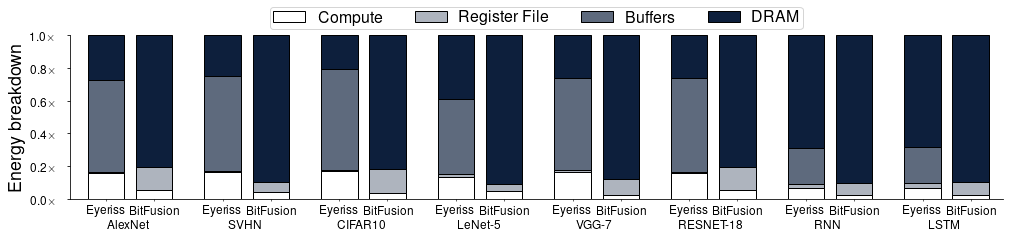

In [9]:
bc = BarChart()
bc.LABEL_BAR = False
bc.BAR_LEFT_MARGIN = 1
bc.BAR_GAP = 0.1
bc.YAXIS_MAX = 1
bc.ISTIMES = True
bc.TOP_ROTATE = True
bc.LEGEND_LOCATION = "upper center"
bc.LEGEND_NCOLUMN = 5
bc.MV_LEGEND_OUTSIDE_Y = 1.2
bc.MV_LEGEND_OUTSIDE_X = 0.5
bc.LOG_SCALE = False
bc.FIG_WIDTH = 16
bc.TOP_LABEL_FONTSIZE = 12
bc.LEGEND_FONTSIZE = 16

# print(eyeriss_comparison_df)

# print('Generating Figure for GPU performance comparison')
bc.yaxis = 'Energy breakdown'
bc.BAR_WIDTH = None
legend_list = ['Eyeriss', 'BitFusion']
fig_name = os.path.join(fig_dir, 'bitfusion-eyeriss-energy-breakdown.pdf')
bc.plot(fig_name, breakdown_df, x_plot='Network', y_plot=['Compute', 'Register File', 'Buffers', 'DRAM'], bar_plot='Platform',
        bar_list=legend_list)

## GPU numbers

In [10]:
gpu_data = []
gpu_list = ['TX2-fp32', 'TitanX-fp32', 'TitanX-int8']
config = ConfigParser.ConfigParser()
config.read('results/output.ini')
for bench in benchmarks.benchlist:
    # Titan-X Pascal numbers
    titanx_fp32_sec = '{}-performance-batch-{}'.format('TitanX-fp32', batch_size)    
    titanx_int8_sec = '{}-performance-batch-{}'.format('TitanX-int8', batch_size)
    titanx_fp32_time = config.getfloat(titanx_fp32_sec, bench.lower())
    titanx_int8_time = config.getfloat(titanx_int8_sec, bench.lower())    
    titanx_fp32_fps = batch_size / titanx_fp32_time * 1.e3
    titanx_int8_fps = batch_size / titanx_int8_time * 1.e3
    int8_speedup = titanx_int8_fps/titanx_fp32_fps
    
    gpu_data.append(['TitanX', bench, 'fp32', titanx_fp32_fps, batch_size])
    gpu_data.append(['TitanX', bench, 'int8', titanx_int8_fps, batch_size])
    
    # Jetson-TX2 numbers
    tx2_fp32_sec = '{}-performance-batch-{}'.format('TX2-fp32', batch_size)    
    tx2_int8_sec = '{}-performance-batch-{}'.format('TX2-int8', batch_size)
    tx2_fp32_time = config.getfloat(tx2_fp32_sec, bench.lower())
    try:
        tx2_int8_time = config.getfloat(tx2_int8_sec, bench.lower())
    except:
        # ID4A speedup
        tx2_int8_time = tx2_fp32_time / int8_speedup
    tx2_fp32_fps = batch_size / tx2_fp32_time * 1.e3 * 2
    tx2_int8_fps = batch_size / tx2_int8_time * 1.e3 * 2
    
    gpu_data.append(['TX2', bench, 'fp32', tx2_fp32_fps, batch_size])
    gpu_data.append(['TX2', bench, 'int8', tx2_int8_fps, batch_size])
    
#     print(v100_fp32_time, v100_int8_time)
#     print(titanx_fp32_time, titanx_int8_time)
    
gpu_data = pandas.DataFrame(gpu_data, columns=['Platform', 'Network', 'Precision', 'fps', 'Batch size'])

gpu_fps_df = gpu_data
gpu_fps_df['Name'] = gpu_fps_df['Platform'] + '-' + gpu_fps_df['Precision']
gpu_fps_df = gpu_fps_df[['Name', 'Network', 'fps', 'Batch size']]

print(gpu_fps_df)

           Name    Network            fps  Batch size
0   TitanX-fp32    AlexNet    5555.555556          16
1   TitanX-int8    AlexNet   10884.353741          16
2      TX2-fp32    AlexNet     459.188049          16
3      TX2-int8    AlexNet     899.633729          16
4   TitanX-fp32       SVHN   27118.644068          16
5   TitanX-int8       SVHN   39506.172840          16
6      TX2-fp32       SVHN    1818.575156          16
7      TX2-int8       SVHN    2649.282326          16
8   TitanX-fp32    CIFAR10    9142.857143          16
9   TitanX-int8    CIFAR10   19207.683073          16
10     TX2-fp32    CIFAR10     654.911590          16
11     TX2-int8    CIFAR10    1375.864685          16
12  TitanX-fp32    LeNet-5   87912.087912          16
13  TitanX-int8    LeNet-5  115107.913669          16
14     TX2-fp32    LeNet-5    4230.188957          16
15     TX2-int8    LeNet-5    5538.808563          16
16  TitanX-fp32      VGG-7    9411.764706          16
17  TitanX-int8      VGG-7  

## BitFusion numbers

In [11]:
# Constant for a particular accelerator configuration
accelerator_constants = ['N', 'M',
                         'Max Precision (bits)', 'Min Precision (bits)',
                         'WBUF Size (bits)', 'OBUF Size (bits)', 'IBUF Size (bits)',
                         'Bandwidth (bits/cycle)'
                        ]
# Constant for a particular network run
algorithm_constants = ['Batch size']


# Variables (to be summed) for a particular network run
variable_columns = ['Cycles', 'Memory wait cycles',
                    'WBUF Read', 'WBUF Write',
                    'OBUF Read', 'OBUF Write',
                    'IBUF Read', 'IBUF Write',
                    'DRAM Read', 'DRAM Write',
                   ]

sim_sweep_columns = accelerator_constants + \
                        algorithm_constants + \
                        variable_columns + \
                        ['Network', 'Layer']


# CSV for sweeps
bf_e_sim_sweep_csv = os.path.join(results_dir, 'bitfusion-eyeriss-sim-sweep.csv')
if os.path.exists(bf_e_sim_sweep_csv):
    bf_e_sim_sweep_df = pandas.read_csv(bf_e_sim_sweep_csv)
else:
    bf_e_sim_sweep_df = pandas.DataFrame(columns=sim_sweep_columns)
# print('Got BitFusion Eyeriss Numbers')
# print(bf_e_sim_sweep_df)

bf_e_results = check_pandas_or_run(bf_e_sim, bf_e_sim_sweep_df,
                                   bf_e_sim_sweep_csv, batch_size=batch_size)
bf_e_results = bf_e_results.groupby(['Network', 'Batch size']+accelerator_constants,
                                    as_index=False).agg(np.sum)
frequency = bf_e_sim.accelerator.frequency #500 MHz
bf_e_results['Time (ms)'] = bf_e_results['Cycles'] * 1.e3 / frequency # in ms
bf_e_results['fps'] = batch_size / bf_e_results['Time (ms)'] * 1.e3


for bench in benchmarks.benchlist:
    graph = benchmarks.get_bench_nn(bench)
    bf_e_datarow = lookup_pandas_dataframe(bf_e_results, {'Network': bench})
    cycles = bf_e_datarow.Cycles
    mem_cycles = bf_e_datarow['Memory wait cycles']
            
    print('*'*50)
    print(bench)
    bf_e_fps = float(bf_e_datarow['fps'])
    print('\tAchieved FPS = {:.2f} frames/sec'.format(bf_e_fps))
    tx2_fps = float(lookup_pandas_dataframe(gpu_fps_df, {'Name': 'TX2-fp32', 'Network': bench})['fps'])
    titanx_fps = float(lookup_pandas_dataframe(gpu_fps_df, {'Name': 'TitanX-int8', 'Network': bench})['fps'])
    
    titanx_speedup = titanx_fps / tx2_fps
    bf_e_speedup = bf_e_fps / tx2_fps
    
    print('\tBitfusion speedup over TX2: {}'.format(bf_e_speedup))
    print('\tTitanX speedup over TX2: {}'.format(titanx_speedup))
    
    print('*'*50)

**************************************************
AlexNet
	Achieved FPS = 212.39 frames/sec
	Bitfusion speedup over TX2: 0.462534622567
	TitanX speedup over TX2: 23.7034778206
**************************************************
**************************************************
SVHN
	Achieved FPS = 6072.00 frames/sec
	Bitfusion speedup over TX2: 3.33887782483
	TitanX speedup over TX2: 21.7236954489
**************************************************
**************************************************
CIFAR10
	Achieved FPS = 2428.88 frames/sec
	Bitfusion speedup over TX2: 3.70870887357
	TitanX speedup over TX2: 29.3286656703
**************************************************
**************************************************
LeNet-5
	Achieved FPS = 19495.46 frames/sec
	Bitfusion speedup over TX2: 4.60864934288
	TitanX speedup over TX2: 27.2110571964
**************************************************
**************************************************
VGG-7
	Achieved FPS = 2834.38 frames/se

## Generate performance comparisons

In [12]:
bf_e_fps_df = bf_e_results[['Network', 'fps']]
bf_e_fps_df['Name'] = 'BitFusion-45nm'

all_fps_df = pandas.concat([bf_e_fps_df, gpu_fps_df])[['Network', 'Name', 'fps']]
print(all_fps_df)
platform_list = ['TX2-fp32', 'TitanX-fp32', 'TitanX-int8', 'BitFusion-45nm']
all_fps_df = all_fps_df[all_fps_df['Name'].isin(platform_list)]
# print(all_fps_df)

      Network            Name            fps
0     AlexNet  BitFusion-45nm     212.390371
1     CIFAR10  BitFusion-45nm    2428.876426
2        LSTM  BitFusion-45nm   23726.551494
3     LeNet-5  BitFusion-45nm   19495.457558
4   RESNET-18  BitFusion-45nm     162.999245
5         RNN  BitFusion-45nm   20274.568342
6        SVHN  BitFusion-45nm    6072.000261
7       VGG-7  BitFusion-45nm    2834.375734
0     AlexNet     TitanX-fp32    5555.555556
1     AlexNet     TitanX-int8   10884.353741
2     AlexNet        TX2-fp32     459.188049
3     AlexNet        TX2-int8     899.633729
4        SVHN     TitanX-fp32   27118.644068
5        SVHN     TitanX-int8   39506.172840
6        SVHN        TX2-fp32    1818.575156
7        SVHN        TX2-int8    2649.282326
8     CIFAR10     TitanX-fp32    9142.857143
9     CIFAR10     TitanX-int8   19207.683073
10    CIFAR10        TX2-fp32     654.911590
11    CIFAR10        TX2-int8    1375.864685
12    LeNet-5     TitanX-fp32   87912.087912
13    LeNe

## GPU performance comparison figure

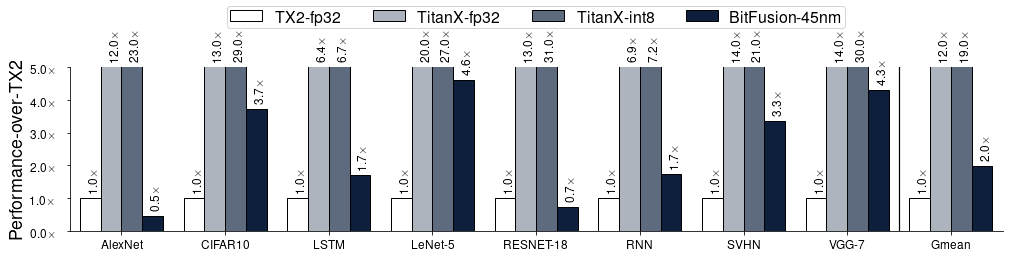

In [13]:
bc = BarChart()
bc.LABEL_BAR = True
bc.BAR_WIDTH = None
bc.YAXIS_MAX = 5
bc.ISTIMES = True
bc.TOP_ROTATE = True
bc.LEGEND_LOCATION = "upper center"
bc.LEGEND_NCOLUMN = 5
bc.MV_LEGEND_OUTSIDE_Y = 1.4
bc.MV_LEGEND_OUTSIDE_X = 0.5
bc.LOG_SCALE = False
bc.FIG_WIDTH = 16
bc.TOP_LABEL_FONTSIZE = 12
bc.LEGEND_FONTSIZE = 16

# print('Generating Figure for GPU performance comparison')
bc.yaxis = 'Performance-over-TX2'
bc.BAR_WIDTH = None
platform_list = ['TX2-fp32', 'TitanX-fp32', 'TitanX-int8', 'BitFusion-45nm']
fig_name = os.path.join(fig_dir, 'performance-gpu.pdf')
bc.plot(fig_name, all_fps_df, x_plot='Network', y_plot='fps', bar_plot='Name',
        bar_list=platform_list, add_geomean=True, baseline='TX2-fp32')

## Get 2x, 4x, and 8x area performance for bitfusion

In [14]:
bf_fps_df = pandas.DataFrame(columns=['Name', 'Network', 'fps'])
df_list = []
for factor in [1, 2, 4, 8]:
    config_file = 'bf_e_conf.ini'
    verbose = False
    bf_scaled = Simulator(config_file, verbose)
    bf_scaled.accelerator.M *= factor
    bf_scaled.accelerator.sram['act'] *= factor
    bf_scaled.accelerator.sram['wgt'] *= factor
    bf_scaled.accelerator.sram['out'] *= factor
#     if bf_scaled.accelerator.mem_if_width * factor > 1024:
#         bf_scaled.accelerator.mem_if_width = 1024
#     else:
#         bf_scaled.accelerator.mem_if_width = bf_scaled.accelerator.mem_if_width * factor
#     bf_scaled.accelerator.mem_if_width = bf_scaled.accelerator.mem_if_width * factor
    bf_scaled.accelerator.mem_if_width = 4096
    frequency = bf_scaled.accelerator.frequency
#     print(bf_scaled)
    bf_e_scaled_results = check_pandas_or_run(bf_scaled, bf_e_sim_sweep_df,
                                       bf_e_sim_sweep_csv, batch_size=batch_size)
    bf_e_scaled_results = bf_e_scaled_results.groupby(['Network', 'Batch size']+accelerator_constants,
                                    as_index=False).agg(np.sum)
    bf_e_scaled_results['fps'] = batch_size * frequency / (bf_e_scaled_results.Cycles)
    bf_e_scaled_results['Name'] = 'BitFusion ({}x)'.format(factor)
    bf_e_scaled_results = bf_e_scaled_results[['Name', 'Network', 'fps']]
    df_list.append(bf_e_scaled_results)
    
bf_fps_df = pandas.concat(df_list)
all_fps_df = pandas.concat([all_fps_df, bf_fps_df])
print(all_fps_df)

Can't find binary file /Users/hardik/workspace/projects/fraqnn-kaist/bitfusion/bitfusion/src/simulator/../../sram/cacti/cacti. Please clone and compile cacti first
Can't find binary file /Users/hardik/workspace/projects/fraqnn-kaist/bitfusion/bitfusion/src/simulator/../../sram/cacti/cacti. Please clone and compile cacti first
Can't find binary file /Users/hardik/workspace/projects/fraqnn-kaist/bitfusion/bitfusion/src/simulator/../../sram/cacti/cacti. Please clone and compile cacti first
Can't find binary file /Users/hardik/workspace/projects/fraqnn-kaist/bitfusion/bitfusion/src/simulator/../../sram/cacti/cacti. Please clone and compile cacti first
              Name    Network            fps
0   BitFusion-45nm    AlexNet     212.390371
1   BitFusion-45nm    CIFAR10    2428.876426
2   BitFusion-45nm       LSTM   23726.551494
3   BitFusion-45nm    LeNet-5   19495.457558
4   BitFusion-45nm  RESNET-18     162.999245
5   BitFusion-45nm        RNN   20274.568342
6   BitFusion-45nm       SVHN

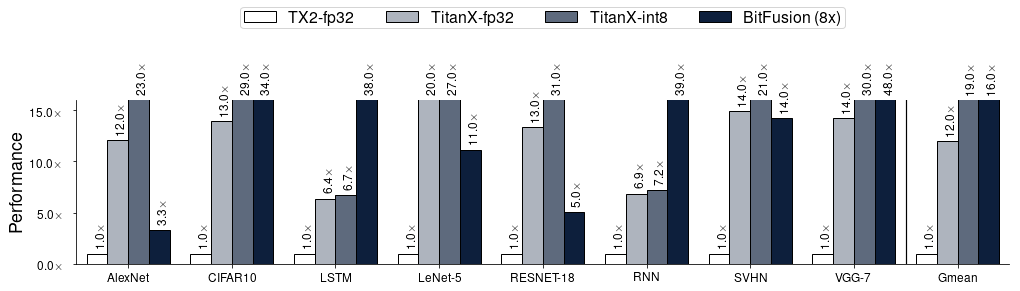

In [15]:
bc = BarChart()
bc.LABEL_BAR = True
bc.BAR_WIDTH = None
bc.YAXIS_MAX = 16
bc.FIG_WIDTH = 16
bc.TOP_LABEL_FONTSIZE = 12
bc.LEGEND_FONTSIZE = 16
bc.ISTIMES = True
bc.TOP_ROTATE = True
bc.LEGEND_LOCATION = "upper center"
bc.LEGEND_NCOLUMN = 5
bc.MV_LEGEND_OUTSIDE_Y = 1.6
bc.MV_LEGEND_OUTSIDE_X = 0.5
bc.LOG_SCALE = False

# print('Generating Figure for GPU performance comparison')
bc.yaxis = 'Performance'
bc.BAR_WIDTH = None
fig_name = os.path.join(fig_dir, 'performance-eyeriss-comparision.pdf')
platform_list = ['TX2-fp32', 'TitanX-fp32', 'TitanX-int8', 'BitFusion (8x)']
bc.plot(fig_name, all_fps_df, x_plot='Network', y_plot='fps', bar_plot='Name',
        bar_list=platform_list, add_geomean=True, baseline='TX2-fp32')